In [1]:
using GeophysicalFlows, CairoMakie, Printf
using Random: seed!

using FourierFlows: parsevalsum2

In [ ]:
dev = GPU()
n = 128
stepper = "FilteredAB3"
dt = 5e-3
nsteps = 50000
nsubs = 50

In [ ]:
L = 2π
μ = 0
β = 0

nlayers = 2
f₀ = 1
H = [0.5, 0.5]
b = [-1.0, -1.2]

U = [0.5, -0.5]

In [ ]:
prob = MultiLayerQG.Problem(nlayers, dev; 
    nx=n, Lx=L, f₀, H, b, U, μ, β, dt, stepper, aliased_fraction=0)
sol, clock, params, vars, grid = prob.sol, prob.clock, prob.params, prob.vars, prob.grid
x, y = grid.x, grid.y

In [ ]:
seed!(1234)
background_energy = 0.0
bc_energy = 0.1
bt_energy = 0.1
k0_min = 13
k0_max = 15
k_filter = k0_min^2 .<= grid.Krsq .< k0_max^2

θ_bt = device_array(dev)(rand(Float64, (grid.nkr, grid.nl)))
θ_bc = device_array(dev)(rand(Float64, (grid.nkr, grid.nl)))
ψh_bt = @. exp(2*π*im*θ_bt) * k_filter
ψh_bc = @. exp(2*π*im*θ_bc) * k_filter

ψh_bt *= sqrt(bt_energy / parsevalsum2(sqrt.(grid.Krsq) .* ψh_bt, grid))
ψh_bc *= sqrt(bc_energy / parsevalsum2(sqrt.(grid.Krsq) .* ψh_bc, grid))

ψ_top = @. background_energy * cos(0*x + y')
ψ_bot = @. -background_energy * cos(0*x + y')
ψ = cat(ψ_top, ψ_bot; dims=3)
ψh = rfft(ψ, (1, 2))
ψh[:, :, 1] += ψh_bt + ψh_bc
ψh[:, :, 2] += ψh_bt - ψh_bc

MultiLayerQG.pvfromstreamfunction!(prob.sol, ψh, params, grid)
MultiLayerQG.updatevars!(prob)

In [ ]:
E = Diagnostic(MultiLayerQG.energies, prob; nsteps)
diags = [E]

In [ ]:
filepath = "."
plotpath = "./plots_2layer"
plotname = "snapshots"
filename = joinpath(filepath, "2layer_siny.jld2")

In [ ]:
if isfile(filename); rm(filename); end
if !isdir(plotpath); mkdir(plotpath); end

In [ ]:
get_sol(prob) = prob.sol # extracts the Fourier-transformed solution

function get_u(prob)
  sol, params, vars, grid = prob.sol, prob.params, prob.vars, prob.grid

  @. vars.qh = sol
  streamfunctionfrompv!(vars.ψh, vars.qh, params, grid)
  @. vars.uh = -im * grid.l * vars.ψh
  invtransform!(vars.u, vars.uh, params)

  return vars.u
end

out = Output(prob, filename, (:sol, get_sol), (:u, get_u))

In [ ]:
Lx, Ly = grid.Lx, grid.Ly

title_KE = Observable(@sprintf("μt = %.2f", μ * clock.t))

q₁ = Observable(Array(vars.q[:, :, 1]))
ψ₁ = Observable(Array(vars.ψ[:, :, 1]))
q₂ = Observable(Array(vars.q[:, :, 2]))
ψ₂ = Observable(Array(vars.ψ[:, :, 2]))

function compute_levels(maxf, nlevels=8)
  # -max(|f|):...:max(|f|)
  levelsf  = @lift collect(range(-$maxf, stop = $maxf, length=nlevels))

  # only positive
  levelsf⁺ = @lift collect(range($maxf/(nlevels-1), stop = $maxf, length=Int(nlevels/2)))

  # only negative
  levelsf⁻ = @lift collect(range(-$maxf, stop = -$maxf/(nlevels-1), length=Int(nlevels/2)))

  return levelsf, levelsf⁺, levelsf⁻
end

maxψ₁ = Observable(maximum(abs, vars.ψ[:, :, 1]))
maxψ₂ = Observable(maximum(abs, vars.ψ[:, :, 2]))

levelsψ₁, levelsψ₁⁺, levelsψ₁⁻ = compute_levels(maxψ₁)
levelsψ₂, levelsψ₂⁺, levelsψ₂⁻ = compute_levels(maxψ₂)

KE₁ = Observable(Point2f[(f₀ * E.t[1], E.data[1][1][1])])
KE₂ = Observable(Point2f[(f₀ * E.t[1], E.data[1][1][2])])
PE  = Observable(Point2f[(f₀ * E.t[1], E.data[1][2])])

fig = Figure(size=(1000, 600))

axis_kwargs = (xlabel = "x",
               ylabel = "y",
               aspect = 1,
               limits = ((-Lx/2, Lx/2), (-Ly/2, Ly/2)))

axq₁ = Axis(fig[1, 1]; title = "q₁", axis_kwargs...)

axψ₁ = Axis(fig[2, 1]; title = "ψ₁", axis_kwargs...)

axq₂ = Axis(fig[1, 2]; title = "q₂", axis_kwargs...)

axψ₂ = Axis(fig[2, 2]; title = "ψ₂", axis_kwargs...)

axKE = Axis(fig[1, 3],
            xlabel = "μ t",
            ylabel = "KE",
            title = title_KE,
            yscale = log10,
            limits = ((-0.1, 2.6), (1e-9, 5)))

axPE = Axis(fig[2, 3],
            xlabel = "μ t",
            ylabel = "PE",
            yscale = log10,
            limits = ((-0.1, 2.6), (1e-9, 5)))

heatmap!(axq₁, x, y, q₁; colormap = :balance)

heatmap!(axq₂, x, y, q₂; colormap = :balance)

contourf!(axψ₁, x, y, ψ₁;
          levels = levelsψ₁, colormap = :viridis, extendlow = :auto, extendhigh = :auto)
 contour!(axψ₁, x, y, ψ₁;
          levels = levelsψ₁⁺, color=:black)
 contour!(axψ₁, x, y, ψ₁;
          levels = levelsψ₁⁻, color=:black, linestyle = :dash)

contourf!(axψ₂, x, y, ψ₂;
          levels = levelsψ₂, colormap = :viridis, extendlow = :auto, extendhigh = :auto)
 contour!(axψ₂, x, y, ψ₂;
          levels = levelsψ₂⁺, color=:black)
 contour!(axψ₂, x, y, ψ₂;
          levels = levelsψ₂⁻, color=:black, linestyle = :dash)

ke₁ = lines!(axKE, KE₁; linewidth = 3)
ke₂ = lines!(axKE, KE₂; linewidth = 3)
Legend(fig[1, 4], [ke₁, ke₂,], ["KE₁", "KE₂"])

lines!(axPE, PE; linewidth = 3)

fig

In [ ]:
startwalltime = time()

frames = 0:round(Int, nsteps / nsubs)

record(fig, "multilayerqg_2layer.mp4", frames, framerate = 18) do j
  if j % (1000 / nsubs) == 0
    cfl = clock.dt * maximum([maximum(vars.u) / grid.dx, maximum(vars.v) / grid.dy])

    log = @sprintf("step: %04d, t: %.1f, cfl: %.2f, KE₁: %.3e, KE₂: %.3e, PE: %.3e, walltime: %.2f min",
                   clock.step, clock.t, cfl, E.data[E.i][1][1], E.data[E.i][1][2], E.data[E.i][2][1], (time()-startwalltime)/60)

    println(log)
  end

  q₁[] = vars.q[:, :, 1]
  ψ₁[] = vars.ψ[:, :, 1]
  q₂[] = vars.q[:, :, 2]
  ψ₂[] = vars.ψ[:, :, 2]

  maxψ₁[] = maximum(abs, vars.ψ[:, :, 1])
  maxψ₂[] = maximum(abs, vars.ψ[:, :, 2])

  KE₁[] = push!(KE₁[], Point2f(f₀ * E.t[E.i], E.data[E.i][1][1]))
  KE₂[] = push!(KE₂[], Point2f(f₀ * E.t[E.i], E.data[E.i][1][2]))
  PE[]  = push!(PE[] , Point2f(f₀ * E.t[E.i], E.data[E.i][2]))

  title_KE[] = @sprintf("μ t = %.2f", μ * clock.t)

  stepforward!(prob, diags, nsubs)
  MultiLayerQG.updatevars!(prob)
end

In [1]:
using JLD2
using CairoMakie
file = jldopen("/scratch/nad9961/twolayer_simulation/45500243/initial_condition_512x512_U=0.63_freely_evolve.jld2")
file

JLDFile /scratch/nad9961/twolayer_simulation/45500243/initial_condition_512x512_U=0.63_freely_evolve.jld2 (read-only)
 ├─📂 eqn
 │  ├─🔢 L
 │  ├─🔢 dims
 │  └─🔢 T
 ├─📂 clock
 │  └─🔢 dt
 ├─📂 grid
 │  ├─🔢 nx
 │  └─ ⋯ (5 more entries)
 └─ ⋯ (2 more entries)

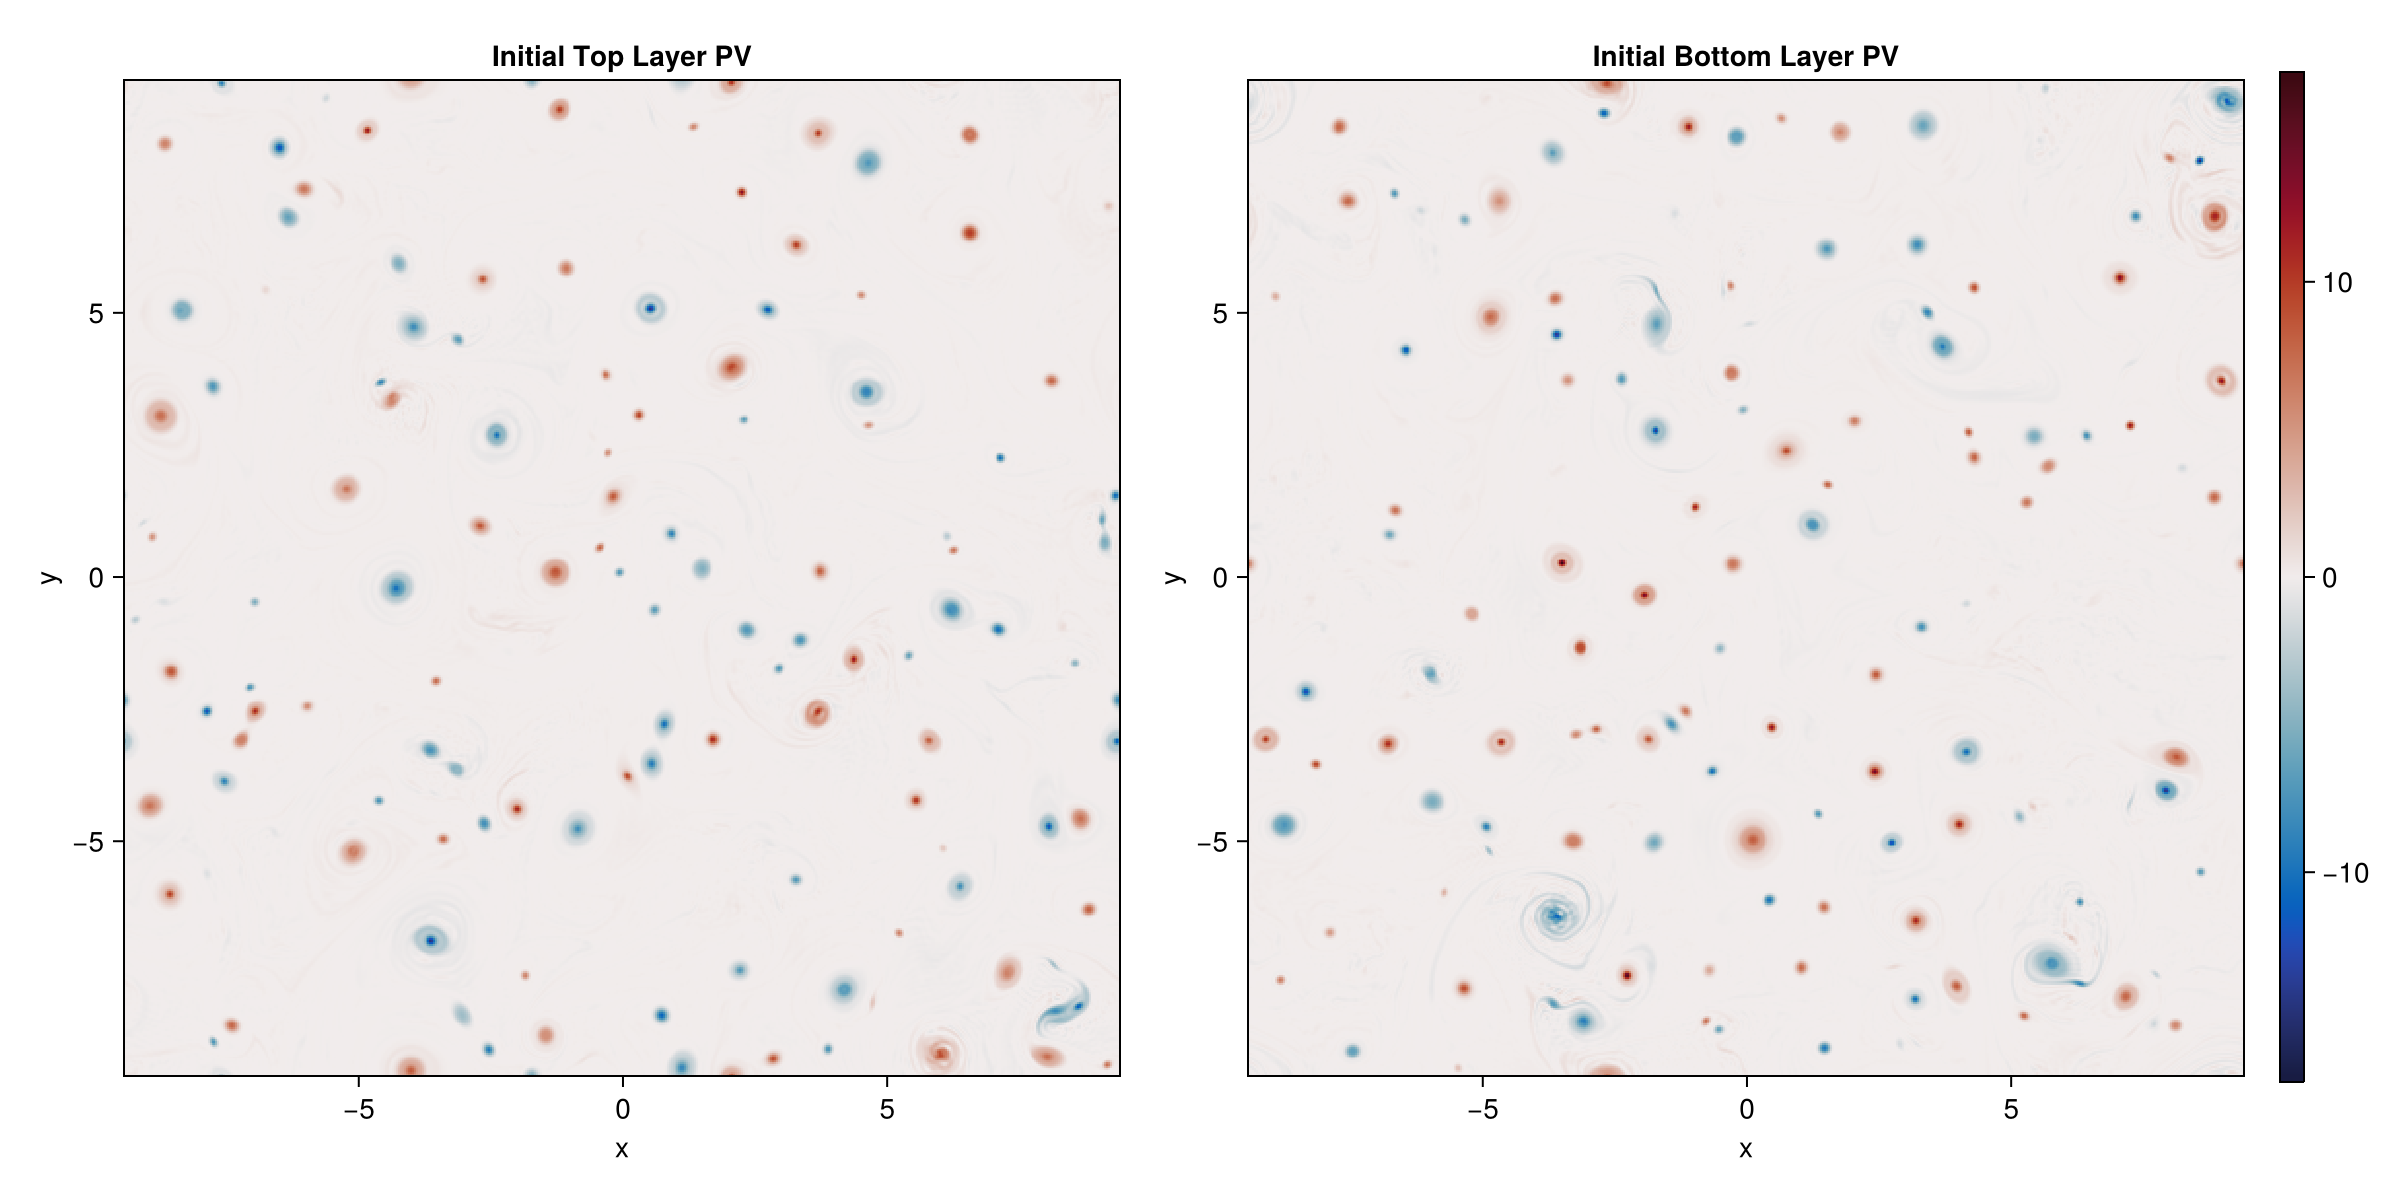

In [31]:
using FourierFlows
using GeophysicalFlows
using UnPack
ψh = file["/snapshots/ψh/343613"]
nx = file["grid/nx"]
ny = file["grid/ny"]
Lx = file["grid/Lx"]
Ly = file["grid/Ly"]
# close(file)
grid = TwoDGrid(CPU(); nx, Lx, ny, Ly, aliased_fraction=0, T=Float64)
@unpack f₀, β, b, H, U, μ = file["params"]
dt = file["clock/dt"]
nlayers = 2
L = 2π
nx = size(ψh, 2)
U = U[1,1,:]
b = [b[1], b[2]]
prob = MultiLayerQG.Problem(nlayers, CPU(); nx, Lx=L, f₀, H, b, U, μ, β, dt, stepper="RK4", aliased_fraction=0)
MultiLayerQG.pvfromstreamfunction!(prob.sol, ψh, prob.params, prob.grid)
MultiLayerQG.updatevars!(prob)
fig = Figure(size=(1200, 600))
ax1 = Axis(fig[1, 1]; title = "Initial Top Layer PV", xlabel="x", ylabel="y", aspect=1)
ax2 = Axis(fig[1, 2]; title = "Initial Bottom Layer PV", xlabel="x", ylabel="y", aspect=1)
cmax = maximum(abs.(prob.vars.q))
heatmap!(ax1, grid.x, grid.y, prob.vars.q[:,:,1], colormap=:balance, colorrange=(-cmax, cmax))
hm = heatmap!(ax2, grid.x, grid.y, prob.vars.q[:,:,2], colormap=:balance, colorrange=(-cmax, cmax))
Colorbar(fig[1,3], hm)
fig

In [6]:
prob.eqn.L

65×128×2 Array{Float64, 3}:
[:, :, 1] =
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0